In [64]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import warnings

In [65]:
warnings.filterwarnings("ignore", category=FutureWarning)

### Dataset

In [66]:
df_edges = pd.read_csv('data/FR_edges.csv')       # Arrête
df_nodes = pd.read_csv('data/FR_target.csv')      # Noeud
print(df_edges.head())
print(df_nodes.head())

   from    to
0     0  6420
1     0  2941
2     0  3051
3     0  5511
4     0  1020
          id  days  mature  views  partner  new_id
0  150417538   577    True    775    False    4867
1  125723704   861    True   2585    False    3692
2  155971814   523   False   1566    False    3816
3   35832890  2234   False   9713    False     416
4   46787750  1896    True  44529    False    4502


In [67]:
new_id_to_id = {row['new_id']: row['id'] for index, row in df_nodes.iterrows()}  # Dictionnaire pour retrouver l'id original

In [68]:
G = nx.Graph()
for index, row in df_edges.iterrows():
    G.add_edge(row["from"], row["to"])
for index, row in df_nodes.iterrows():
    G.nodes(row['new_id'])
G.number_of_nodes(), G.number_of_edges()

(6549, 112666)

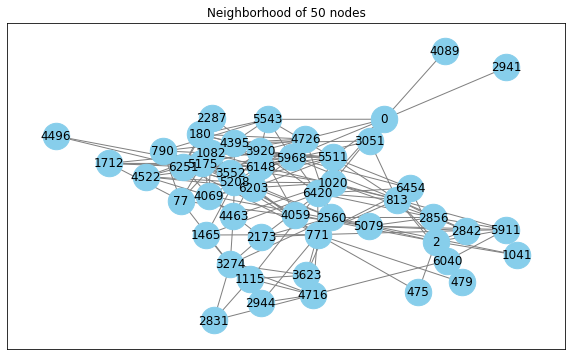

In [69]:
node_examples = list(G.nodes(data=True))[:50]
sub_G = G.subgraph([node[0] for node in node_examples])
plt.figure(figsize=(10, 6))
nx.draw_networkx(sub_G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=700, font_size=12)
plt.title("Neighborhood of 50 nodes")
plt.show()

### Prédiction de relation

In [70]:
df_link = df_edges.copy()

In [71]:
# Ajout de la colonne 'link' pour le modèle (1 si lien entre les noeuds, 0 sinon)
df_link['link'] = 1
df_link.head()

,from,to,link
0,0,6420,1
1,0,2941,1
2,0,3051,1
3,0,5511,1
4,0,1020,1


In [72]:
# Générer un nombre égal de paires de noeuds "négatives" (non liées)
nodes = list(G.nodes())
n = len(df_link)
for i in range(n):
    node1, node2 = np.random.choice(nodes, 2, replace=False)
    if not G.has_edge(node1, node2):
        print(f"{i}/{n}", end='\r')
        df_link = df_link._append({'from': node1, 'to': node2, 'link': 0}, ignore_index=True)

In [73]:
# Gnérer les features
def create_features(G, edges):
    days1 = []
    days2 = []
    mature1 = []
    mature2 = []
    views1 = []
    views2 = []
    partner1 = []
    partner2 = []
    for node1, node2 in edges:
        n1 = df_nodes.loc[df_nodes['new_id'] == node1]
        n2 = df_nodes.loc[df_nodes['new_id'] == node2]

        days1.append(n1['days'].values[0])
        days2.append(n2['days'].values[0])
        mature1.append(n1['mature'].values[0])
        mature2.append(n2['mature'].values[0])
        views1.append(n1['views'].values[0])
        views2.append(n2['views'].values[0])
        partner1.append(n1['partner'].values[0])
        partner2.append(n2['partner'].values[0])
    return days1, days2, mature1, mature2, views1, views2, partner1, partner2

In [74]:
features = create_features(G, df_link[['from', 'to']].values)

In [75]:
df_link['days(from)'] = features[0]
df_link['days(to)'] = features[1]
df_link['mature(from)'] = features[2]
df_link['mature(to)'] = features[3]
df_link['views(from)'] = features[4]
df_link['views(to)'] = features[5]
df_link['partner(from)'] = features[6]
df_link['partner(to)'] = features[7]

df_link.head()

,from,to,link,days(from),days(to),mature(from),mature(to),views(from),views(to),partner(from),partner(to)
0,0,6420,1,1035,1311,False,False,3416,62713570,False,True
1,0,2941,1,1035,929,False,False,3416,1837,False,False
2,0,3051,1,1035,1261,False,True,3416,4758509,False,True
3,0,5511,1,1035,2613,False,False,3416,44534929,False,True
4,0,1020,1,1035,2480,False,True,3416,22400233,False,True


In [76]:
# 80% des données pour l'entrainement et 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(df_link.drop(columns=['link', 'from', 'to']), df_link['link'], test_size=0.2, random_state=42)
print(X_train.shape, len(y_train), X_test.shape, len(y_test))

(179791, 8) 179791 (44948, 8) 44948


In [77]:
# Modèle
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [78]:
# Accuracy
acc = clf.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(acc*100))

Accuracy: 80.49%


In [79]:
# Regression Logistique
logReg = LogisticRegression(random_state=42)
logReg.fit(X_train, y_train)
acc = logReg.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(acc*100))

Accuracy: 70.45%


In [80]:
# Classification report
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81     22487
           1       0.82      0.79      0.80     22461

    accuracy                           0.80     44948
   macro avg       0.81      0.80      0.80     44948
weighted avg       0.81      0.80      0.80     44948



<AxesSubplot:>

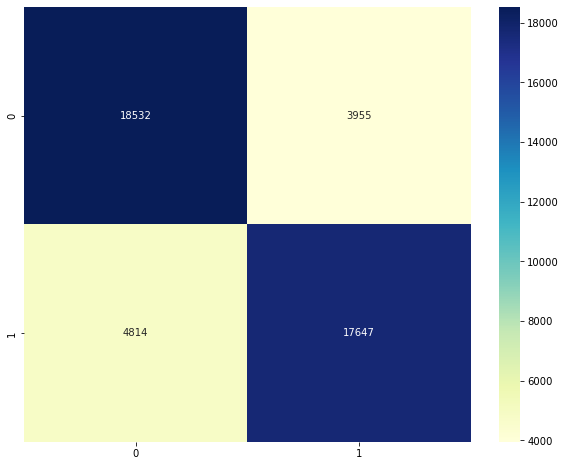

In [81]:
# Matrice de confusion
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), fmt='d', cmap='YlGnBu', ax=ax, annot=True)

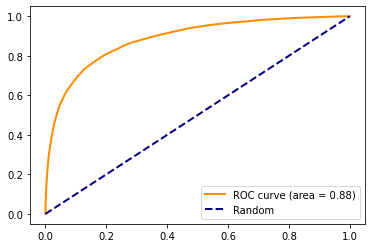

In [82]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.legend(loc="lower right")

### Common neighbors

In [83]:
# Ajoute la feature 'common_neighbors'
def create_features_neighbors(G, edges):
    features = []
    for node1, node2 in edges:
        common_neighbors = len(list(nx.common_neighbors(G, node1, node2)))
        features.append(common_neighbors)
    return np.array(features)

neighbors = create_features_neighbors(G, df_link[['from', 'to']].values)
df_link['common_neighbors'] = neighbors

df_link.head()

,from,to,link,days(from),days(to),mature(from),mature(to),views(from),views(to),partner(from),partner(to),common_neighbors
0,0,6420,1,1035,1311,False,False,3416,62713570,False,True,2
1,0,2941,1,1035,929,False,False,3416,1837,False,False,0
2,0,3051,1,1035,1261,False,True,3416,4758509,False,True,0
3,0,5511,1,1035,2613,False,False,3416,44534929,False,True,3
4,0,1020,1,1035,2480,False,True,3416,22400233,False,True,0


In [84]:
# 80% des données pour l'entrainement et 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(df_link.drop(columns=['link', 'from', 'to']), df_link['link'], test_size=0.2, random_state=42)
print(X_train.shape, len(y_train), X_test.shape, len(y_test))

(179791, 9) 179791 (44948, 9) 44948


In [85]:
# Modèle
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [86]:
# Accuracy
acc = clf.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(acc*100))

Accuracy: 85.65%


In [87]:
# Fine tuning
param_dist = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [5, 10, 20, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rs = RandomizedSearchCV(clf, param_dist, cv=3, random_state=42)
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("Best score:", rs.best_score_)

Best params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': False}
Best score: 0.8562330656931963


Le Fine tuning n'a ici pas trouvé de meilleurs hyperparamètres, il faudrait essayer plus de valeurs mais cela prend trop de temps. <br/>
Nous avons donc décider de garder notre modèle initial.

In [88]:
# Classification report
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86     22487
           1       0.87      0.84      0.85     22461

    accuracy                           0.86     44948
   macro avg       0.86      0.86      0.86     44948
weighted avg       0.86      0.86      0.86     44948



<AxesSubplot:>

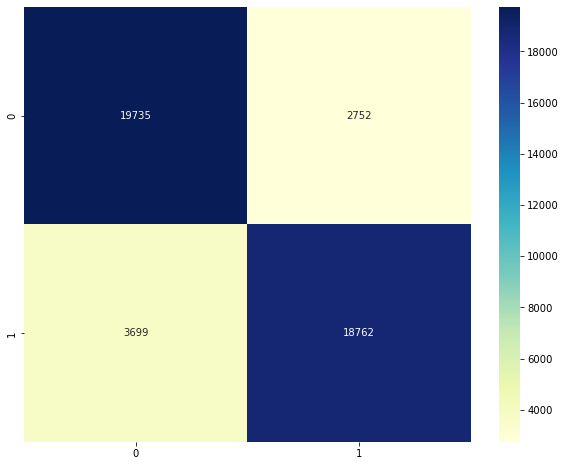

In [89]:
# Matrice de confusion
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), fmt='d', cmap='YlGnBu', ax=ax, annot=True)

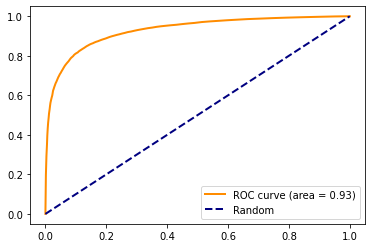

In [90]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.legend(loc="lower right")

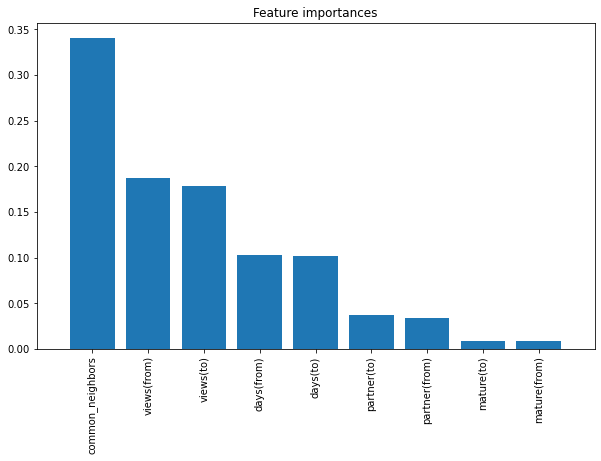

In [91]:
# Importance des features
features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()